# Mobile Price Classification Using Bagging Classifier

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Reading the dataset
data_set = pd.read_csv('train.csv')
data_set.shape

(2000, 21)

In [3]:
# Checking for null values in the dataset
data_set.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [4]:
# Separating the input features and target variable
X = data_set.iloc[:, :-1]
y = data_set['price_range']

In [5]:
# Splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((1600, 20), (400, 20))

In [6]:
# Scaling the features in the training and test sets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Finding the Best Parameters Using Halving Grid Search

In [22]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(criterion='entropy', random_state=0)

In [24]:
# Defining the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_samples': [0.25, 0.5, 1.0],
    'max_features': [0.25, 0.5, 1.0],
    'estimator__min_samples_split': [2, 4, 8],
    'estimator__min_samples_leaf': [1, 2, 4]
}

In [25]:
halving_search = HalvingGridSearchCV(estimator=BaggingClassifier(estimator=estimator, random_state=0),
                                     param_grid=param_grid,
                                     cv=5,
                                     factor=4,  
                                     n_jobs=-1,
                                     verbose=3)

halving_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 40
max_resources_: 1600
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 243
n_resources: 40
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
----------
iter: 1
n_candidates: 61
n_resources: 160
Fitting 5 folds for each of 61 candidates, totalling 305 fits
----------
iter: 2
n_candidates: 16
n_resources: 640
Fitting 5 folds for each of 16 candidates, totalling 80 fits


HalvingGridSearchCV(estimator=BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                 random_state=0),
                                                random_state=0),
                    factor=4, n_jobs=-1,
                    param_grid={'estimator__min_samples_leaf': [1, 2, 4],
                                'estimator__min_samples_split': [2, 4, 8],
                                'max_features': [0.25, 0.5, 1.0],
                                'max_samples': [0.25, 0.5, 1.0],
                                'n_estimators': [25, 50, 100]},
                    verbose=3)

In [26]:
# Best parameters found by HalvingGridSearchCV
print('Best score:',halving_search.best_score_)
print('Best parameters found:',halving_search.best_params_)

Best score: 0.88125
Best parameters found: {'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 4, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


### Visualizing the Results

In [27]:
results = pd.DataFrame(halving_search.cv_results_)

sorted_indices = np.argsort(results['mean_test_score'])[::-1]
sorted_scores = results['mean_test_score'].values[sorted_indices]
sorted_params = results['params'].values[sorted_indices]

top_params = [str(params) for params in sorted_params[:10]]
top_scores = [str(sc) for sc in sorted_scores[:10]]
param_lb = []
for i in range(1,11):
    param_lb.append('Parameter Combination ' + str(i))

print('Top 10 Parameter Combinations:')
for i in range(len(top_params)):
    print('Parmeter Combination',i+1)
    print(top_params[i])
    print('Score:',top_scores[i])
    print()

Top 10 Parameter Combinations:
Parmeter Combination 1
{'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 4, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Score: 0.88125

Parmeter Combination 2
{'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Score: 0.8796875

Parmeter Combination 3
{'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 4, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Score: 0.8796875

Parmeter Combination 4
{'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Score: 0.8703125

Parmeter Combination 5
{'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Score: 0.8703125

Parmeter Combination 6
{'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 4, 'max_features'

## Designing the Bagging Classifier Model with the Optimal Hyperparameters

In [28]:
best_bag_clf = halving_search.best_estimator_

# Making predictions with the best estimator
y_train_pred = best_bag_clf.predict(X_train) # type: ignore
y_test_pred = best_bag_clf.predict(X_test) # type: ignore

In [29]:
# Computing the performance metrics for the training subset
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Training Accuracy (in %):",round(train_accuracy*100,3))
print("Training Precision (in %):",round(train_precision*100,3)) # type: ignore
print("Training Recall (in %):",round(train_recall*100,3)) # type: ignore
print("Training F1 Score (in %):",round(train_f1*100,3)) # type: ignore

Training Accuracy (in %): 100.0
Training Precision (in %): 100.0
Training Recall (in %): 100.0
Training F1 Score (in %): 100.0


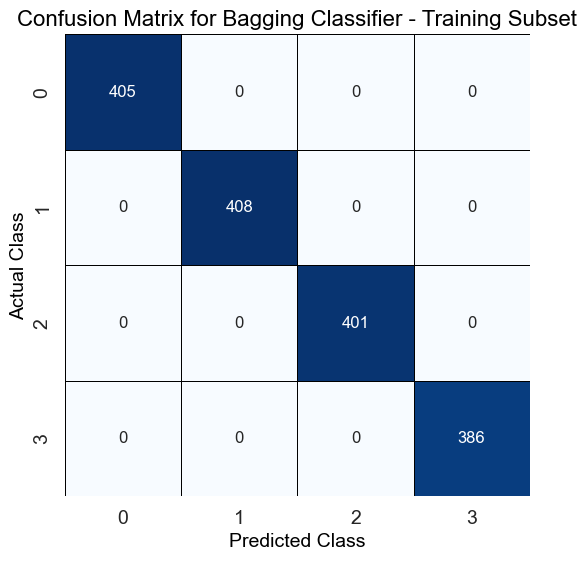

In [30]:
conf_mat_train = confusion_matrix(y_train,y_train_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_train, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_bag_clf.classes_, yticklabels=best_bag_clf.classes_, annot_kws={"size": 12}) # type: ignore
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Bagging Classifier - Training Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

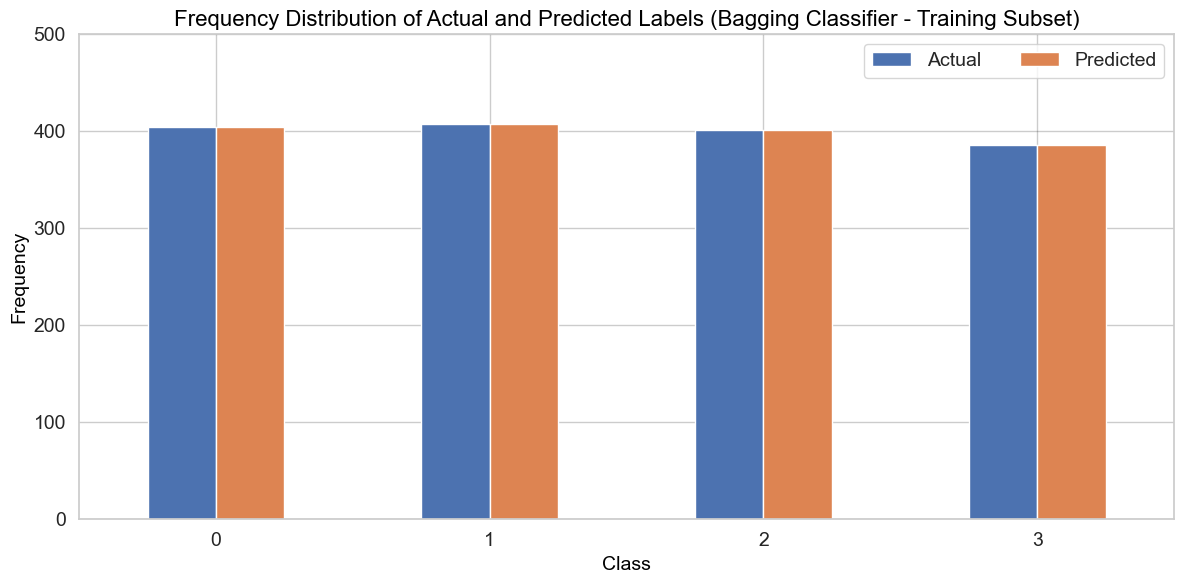

In [31]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_train, actual_counts_train = np.unique(y_train, return_counts=True)
predicted_labels_train, predicted_counts_train = np.unique(y_train_pred, return_counts=True)

labels_train = np.unique(y_train)

x_train = np.arange(len(labels_train))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_train = ax.bar(x_train - width/2, actual_counts_train, width, label='Actual')
rects2_train = ax.bar(x_train + width/2, predicted_counts_train, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Bagging Classifier - Training Subset)', color='black', fontsize=16)
ax.set_xticks(x_train)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_train) - 0.5]) # type: ignore
ax.set_ylim([0,500]) # type: ignore
fig.tight_layout()
plt.show()

In [33]:
# Computing the performance metrics for the test subset
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Accuracy (in %):",round(test_accuracy*100,3))
print("Test Precision (in %):",round(test_precision*100,3)) # type: ignore
print("Test Recall (in %):",round(test_recall*100,3)) # type: ignore
print("Test F1 Score (in %):",round(test_f1*100,3)) # type: ignore

Test Accuracy (in %): 91.25
Test Precision (in %): 91.228
Test Recall (in %): 91.25
Test F1 Score (in %): 91.236


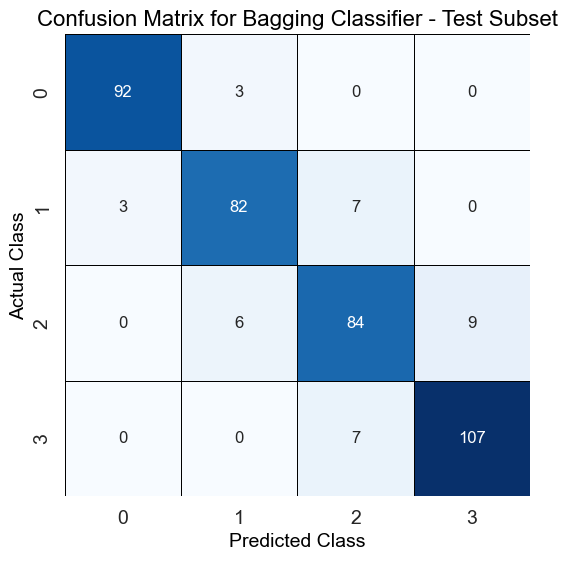

In [34]:
conf_mat_test = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_bag_clf.classes_, yticklabels=best_bag_clf.classes_, annot_kws={"size": 12}) # type: ignore
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Bagging Classifier - Test Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

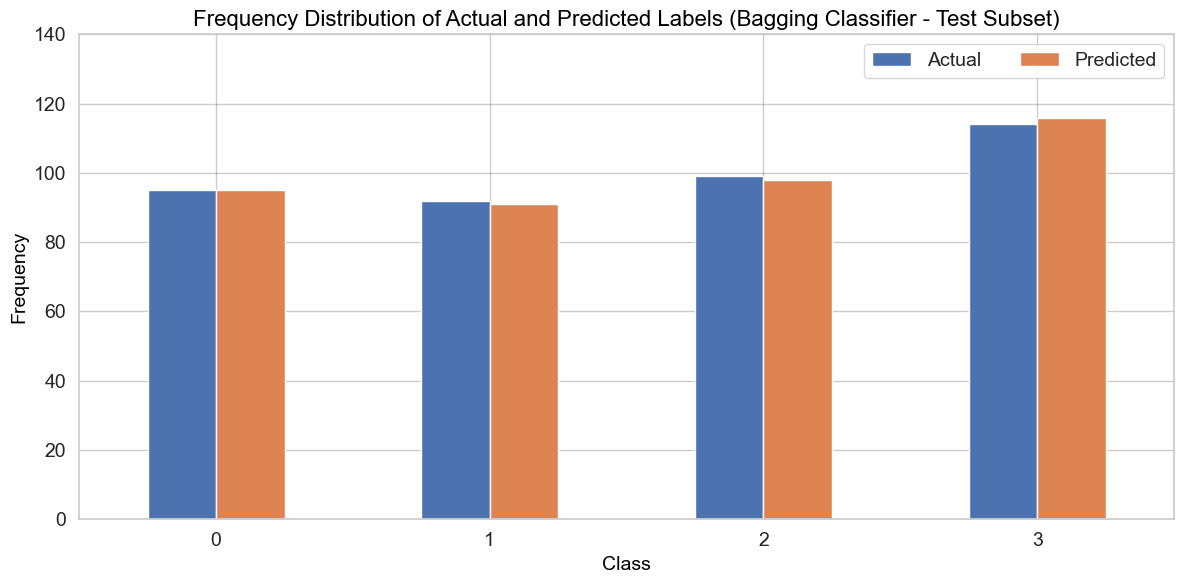

In [35]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_test, actual_counts_test = np.unique(y_test, return_counts=True)
predicted_labels_test, predicted_counts_test = np.unique(y_test_pred, return_counts=True)

labels_test = np.unique(y_test)

x_test = np.arange(len(labels_test))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_test = ax.bar(x_test - width/2, actual_counts_test, width, label='Actual')
rects2_test = ax.bar(x_test + width/2, predicted_counts_test, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Bagging Classifier - Test Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_test) - 0.5]) # type: ignore
ax.set_ylim([0,140]) # type: ignore
fig.tight_layout()
plt.show()

In [36]:
import joblib

# Saving the model
joblib.dump(best_bag_clf, 'Bagging_MobilePrice.pkl')

['Bagging_MobilePrice.pkl']

***